# Simulate resting-state dynamics in macaque brain

This demo shows how to simulate and analyze resting-state dynamics in macaque brain using as connectome a tractography-based connectome optimized thanks to the tracer connectome from Markov et al, 2014 [2]

The results showed here are discussed in Shen et al., 2019 [1]



First, we import all the required dependencies

In [1]:
%pylab nbagg

from tvb.simulator.lab import *



import numpy as np
import time as tm

Populating the interactive namespace from numpy and matplotlib
2020-12-06 13:14:01,152 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
   INFO  Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
   INFO  NumExpr defaulting to 8 threads.
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndi

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.oscillator.SupHopf.state_variable_range = Final(field_type=<class 'dict'>, default={'x': array([-5.,  5.]), 'y': array([-5.,  5.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stef

ModuleNotFoundError: No module named 'tvb.analyzers.correlation_coefficient'

## The Connectome

In order to built the macaque brain network, we used a tractography-based connectome.

In particular, we used a structural connectivity matrix (stored in the data folder of TVB), which is built thanks to 
- averaged across subjects (N=9)
- directed (as informed by tracer data) and weighted (as informed by diffusion imaging data) 

In the following the connectome is loaded in plotted. 

In [4]:
# Load the connectivity data from the directory tvb_data
con = connectivity.Connectivity.from_file('/Applications/TVB_Distribution/my_tvb_workspace/tvb-data/tvb_data/macaque/connectivity_84.zip') 

nregions = len(con.region_labels)                         #number of regions
con.weights = con.weights - con.weights*np.eye(nregions)  #remove self-connection
con.weights = con.weights / np.max(con.weights)           #normalized to its maximum value
con.speed = np.array([4.0])                              #time delays

con.configure()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


<IPython.core.display.Javascript object>


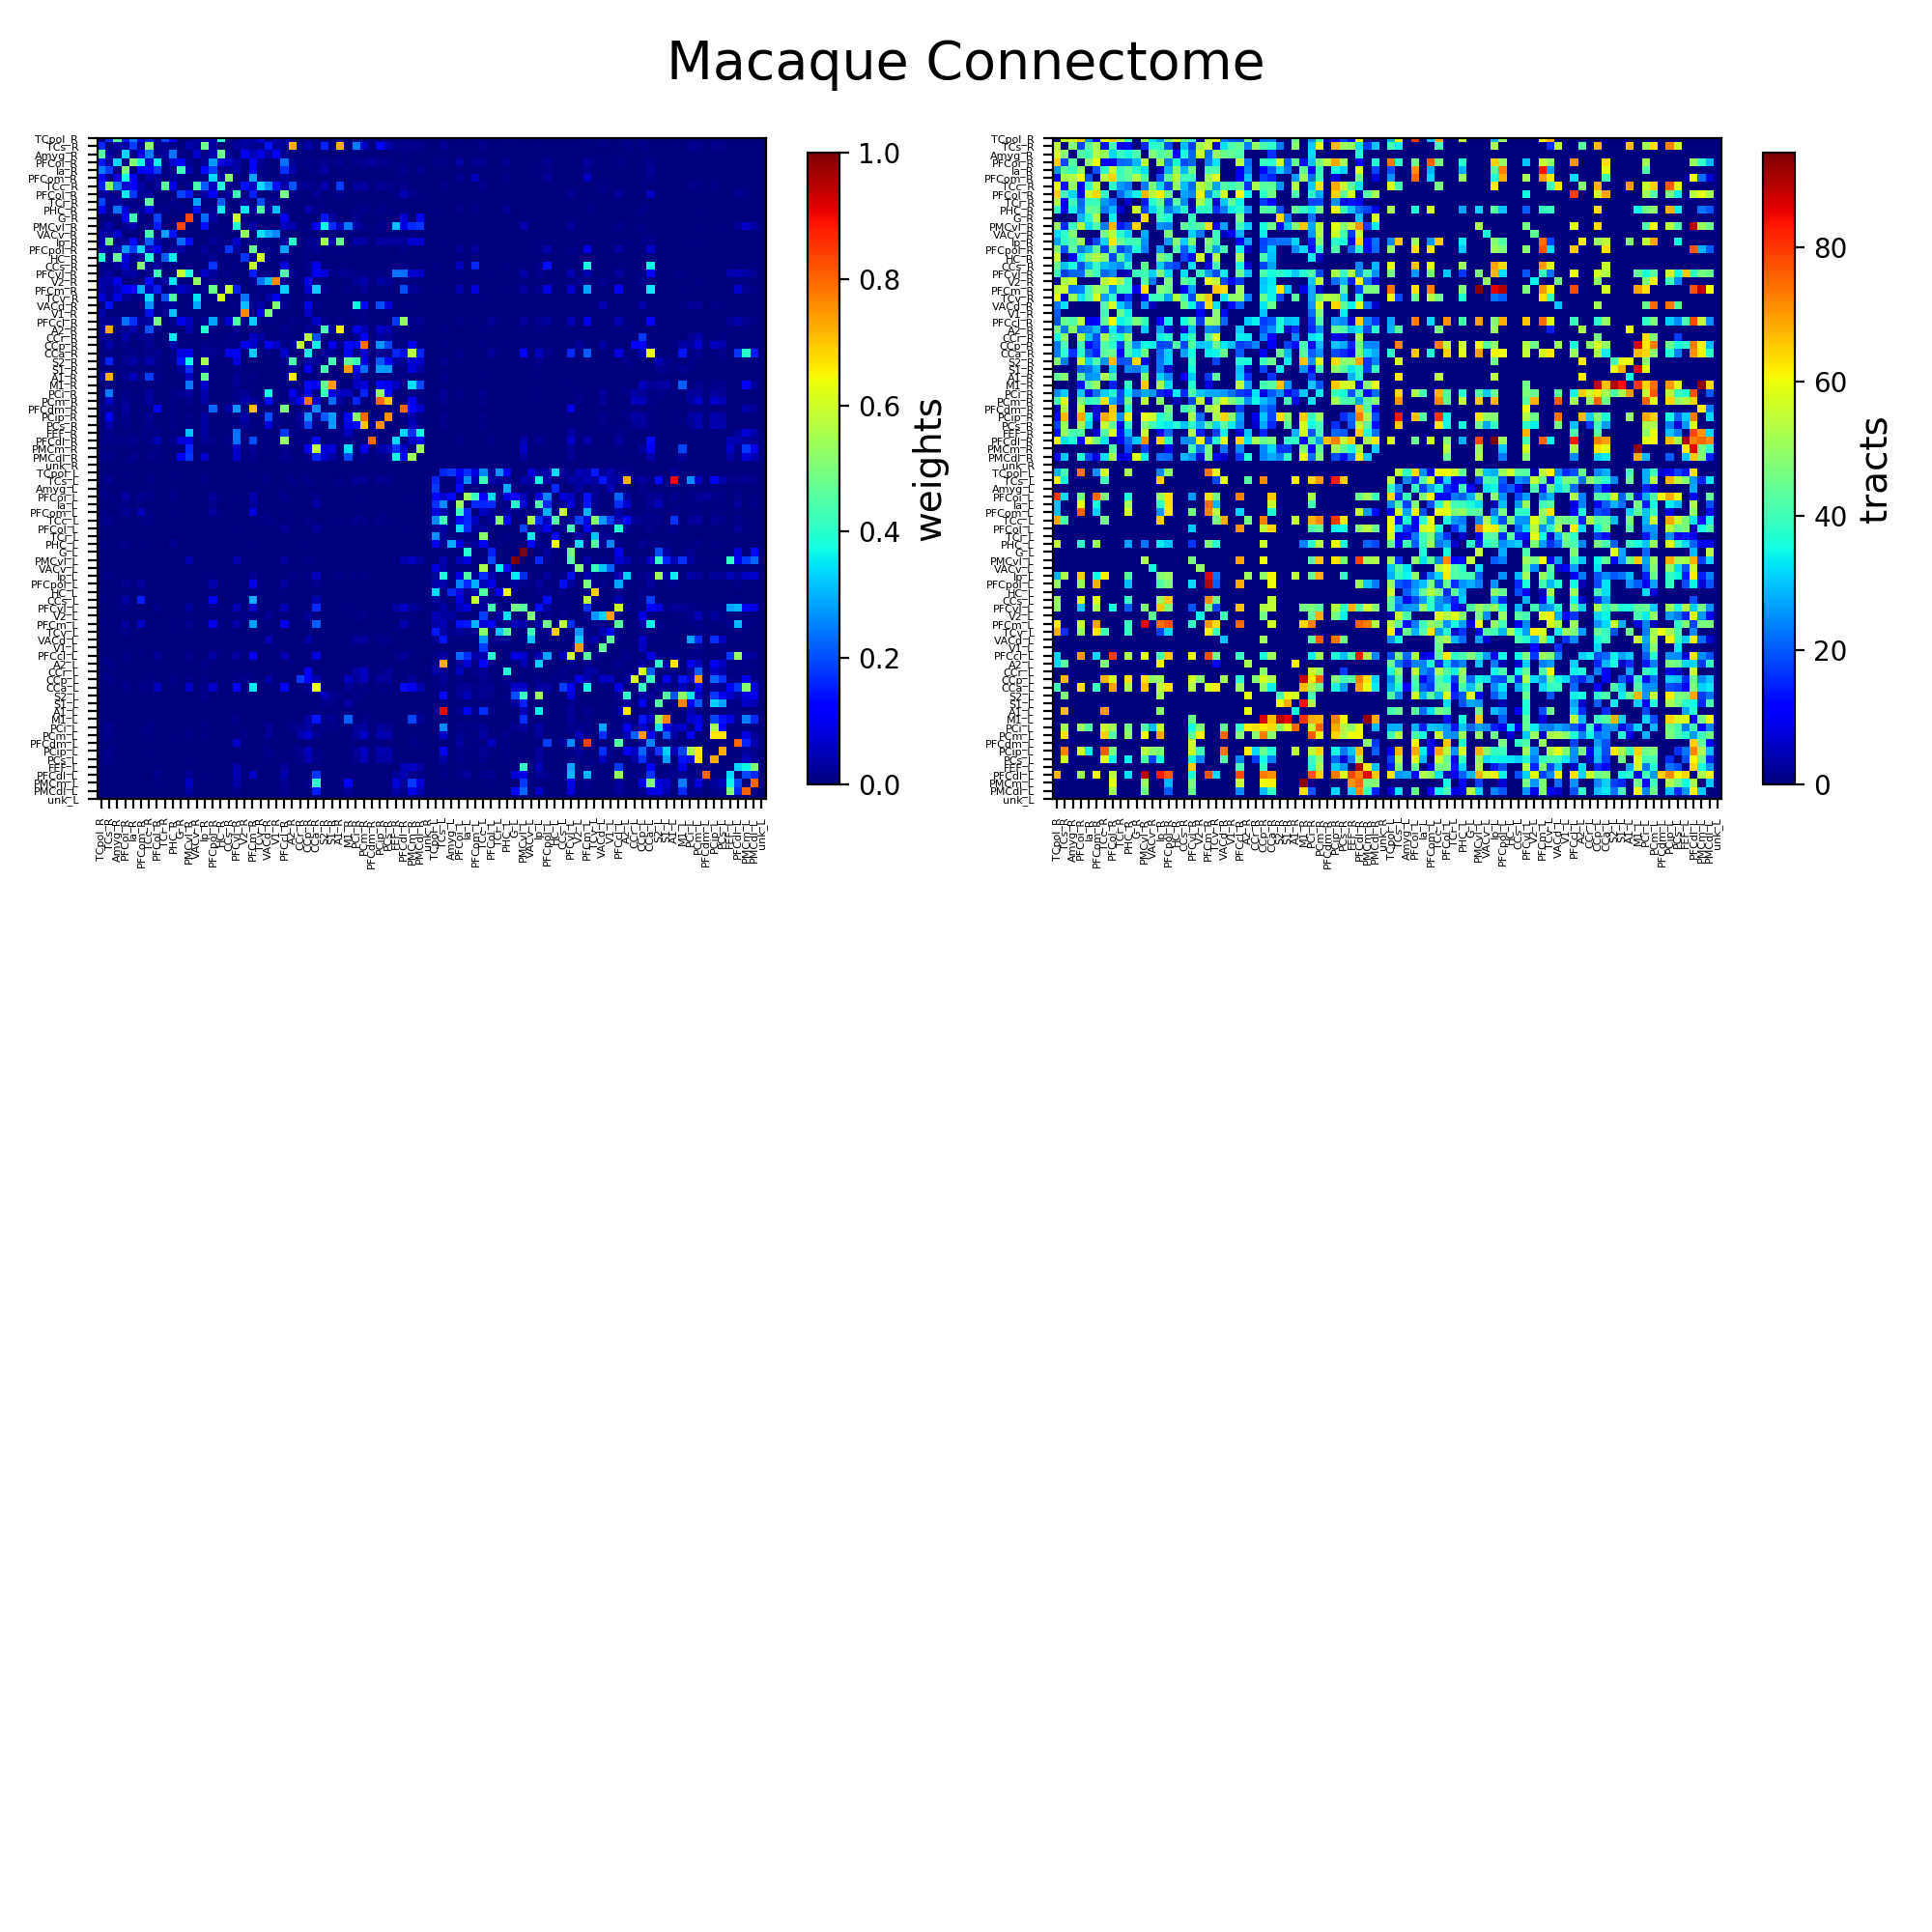

In [5]:
# Visualize the structural connectivity matrix
fig=figure(figsize=(10,10))
fig.suptitle('Macaque Connectome', fontsize=20)

# weights
subplot(121)
imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
xticks(range(0, nregions), con.region_labels, fontsize=4, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=4)
cb=colorbar(shrink=0.22)
cb.set_label('weights', fontsize=14)

#tracts
subplot(122)
imshow(con.tract_lengths, interpolation='nearest', aspect='equal', cmap='jet')
xticks(range(0, nregions), con.region_labels, fontsize=4, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=4)
cb=colorbar(shrink=0.22)
cb.set_label('tracts', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(top=1.5)

show()

## The simulation

Once the brain network is defined is possible to simulate its activity. Here we simulate resting-state dynamics using the reduced Wong Wang model (Deco et al. 2014 [3]).

In order to convert the synaptic activity in BOLD signals we used the Balloon-Windkessel method (Friston et al., 200 [5]) using the default value implemented in The Virtual Brain.

In [14]:
# Set the parameter of the resting state simulation
sim = simulator.Simulator(model=models.ReducedWongWangExcInh(),
                        connectivity=con,
                        coupling=coupling.Linear(a=np.array([0.298])),
                        integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=np.array([0.0255]))),
                        monitors=(monitors.Bold(period=1e3),
                                  monitors.TemporalAverage(period=1e3)),
                        simulation_length=600e3).configure()
# Run the resting-state simulation
(bold_time, bold_data), _ = sim.run()

The simulated bold signals can be visualized using matplotlib library.

<IPython.core.display.Javascript object>


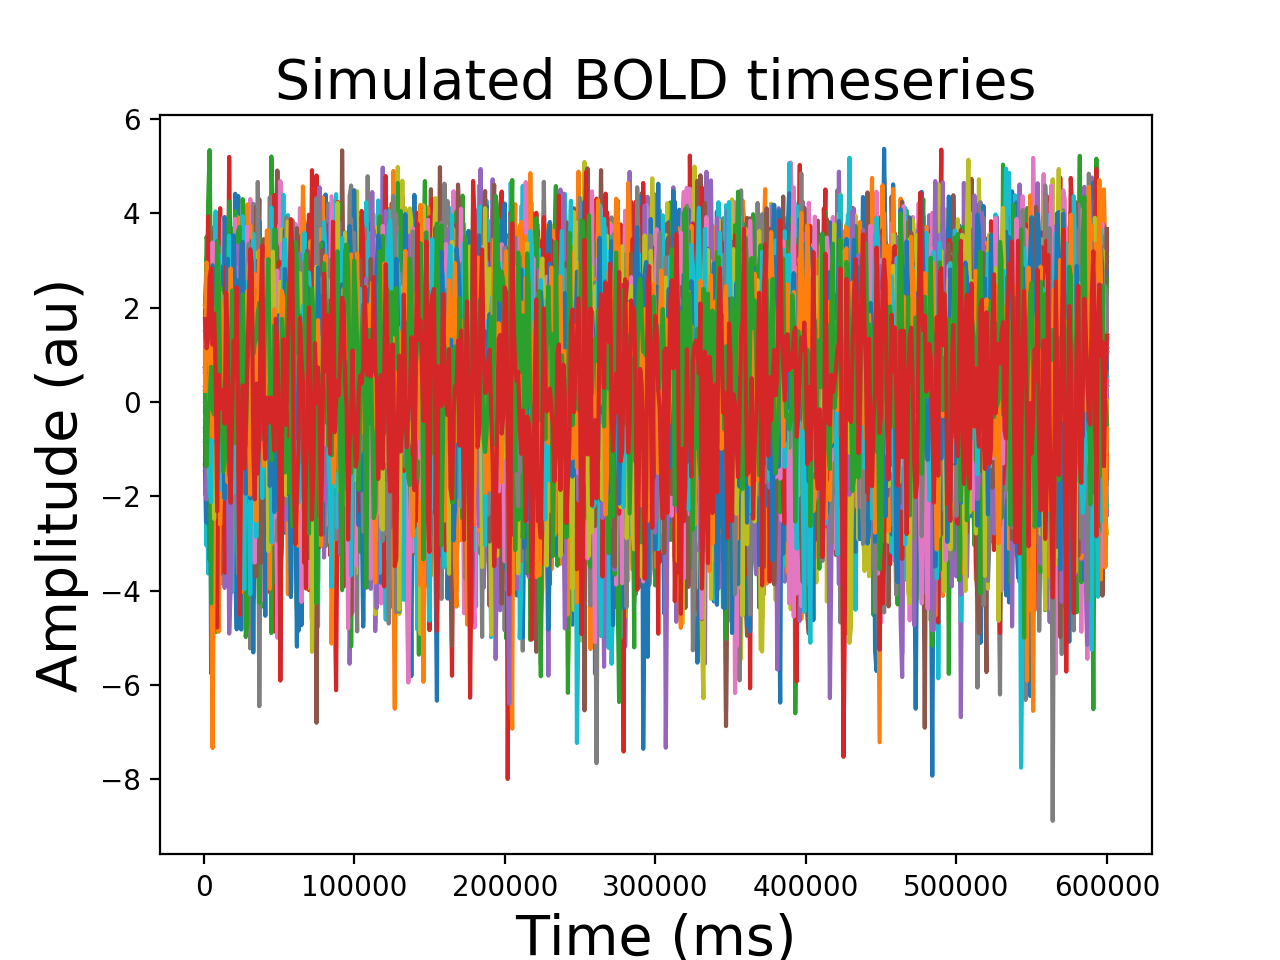

Text(0.5, 1.0, 'Simulated BOLD timeseries')

In [15]:
# Display the simulated bold timeseries
plt.subplots()
plt.plot(bold_time,bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)

## Analysis

The simulated BOLD signals can be analyzed in different way. 

### Functional Connectivity

In particular, here, we focus on the Functional Connectivity (FC) a metric which is able to quantify the 
There are several ways to estimate FC (for a review, TVB uses the

In [16]:
## Calculate the FC matrix for the bold timeseries

from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.correlation_coefficient as corr_coeff

# Build the time series object
tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=bold_data,
                       sample_period=sim.monitors[1].period)
tsr.configure()

# Create and evaluate the analysis
corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
corrcoeff_data = corrcoeff_analyser.evaluate()
corrcoeff_data.configure()

# Store the results
FC = corrcoeff_data.array_data[..., 0, 0]

ModuleNotFoundError: No module named 'tvb.analyzers.correlation_coefficient'

## References

[1] Shen Kelly, Bezgin Gleb, Schirner Michael, Ritter Petra, Everling Stefan and McIntosh Anthony R. "a macaque connectome for large-scale network simulations in TheVirtualBrain". Nature Sci Data (2019) 6:123.

[2] Markov NT, Ercsey-Ravasz MM, Ribeiro Gomes AR et al. "A weighted and directed interareal connectivity matrix for macaque cerebral cortex". Cereb Cortex 24, 17–36 (2014).

[3] Deco, G. et al. How local excitation-inhibition ratio impacts the whole brain dynamics. J. Neurosci. 34, 7886–98 (2014).

[4] Friston, K. J., Mechelli, A., Turner, R. & Price, C. J. Nonlinear responses in fMRI: The balloon model, Volterra kernels, and other hemodynamics. Neuroimage 12, 466–477 (2000).